<a href="https://colab.research.google.com/github/ruksharahmed7/strativ/blob/main/Weather_Forecast/weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import and Basic Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Optional: move to the desired location:
#%cd drive/My Drive/DIRECTORY_IN_YOUR_DRIVE

Mounted at /content/drive


In [ ]:
import pandas as pd
##scale or normalize data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
## Use TimeSeriestrain_generator to generate data in sequences.
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
import joblib
from tensorflow import keras


In [ ]:
# Define a function to suppress log outputs
def suppress_logs():
    tf.get_logger().setLevel('ERROR')  # Set log level to ERROR

# Restore the original log level
def restore_logs():
    tf.get_logger().setLevel('INFO')  # Set log level to INFO or desired level


# Data Loading and Checking

In [ ]:
# Load Data
df = pd.read_csv('drive/MyDrive/Personal/strativ/data/mean_apparent_temp_dhaka.csv')
df.shape

(30565, 2)

In [ ]:
df.head()

,time,apparent_temperature_mean (°C)
0,1940-01-02,17.1
1,1940-01-03,17.0
2,1940-01-04,16.2
3,1940-01-05,16.5
4,1940-01-06,16.6


In [ ]:
# check if temperatures are numerical values and if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30565 entries, 0 to 30564
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            30565 non-null  object 
 1   apparent_temperature_mean (°C)  30565 non-null  float64
dtypes: float64(1), object(1)
memory usage: 477.7+ KB


# Preparing Data for Training

## Make Time Index

In [ ]:
# Set the 'time' column as the index
df.set_index('time', inplace=True)

In [ ]:
df.head()

,apparent_temperature_mean (°C)
time,
1940-01-02,17.1
1940-01-03,17.0
1940-01-04,16.2
1940-01-05,16.5
1940-01-06,16.6


In [ ]:
df.index = pd.to_datetime(df.index) #convert to datetime

In [ ]:
df.head()

,apparent_temperature_mean (°C)
time,
1940-01-02,17.1
1940-01-03,17.0
1940-01-04,16.2
1940-01-05,16.5
1940-01-06,16.6


<Axes: title={'center': 'Apparent Temp in Degree Celcius'}, xlabel='time'>

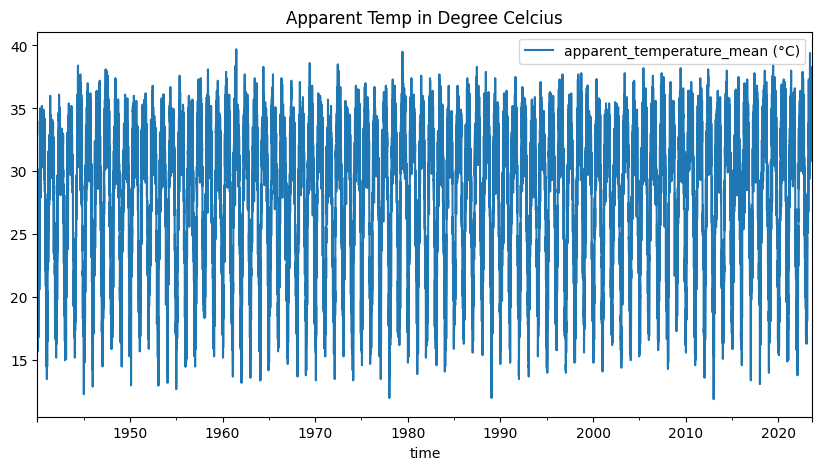

In [ ]:
df.plot(figsize=(10,5),title="Apparent Temp in Degree Celcius")


## Creating Training Data

In [ ]:
#Use data until 14 days before as training
x = len(df)- 14

train=df.iloc[:x]
test = df.iloc[x:]

Scaling the data within 0-1 range.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
#Sequence size has an impact on prediction,
seq_size = 7  ## number of steps (lookback) ## NEED TO CHANGE AND TEST USING THE VALUES 30(MONTHLY), 365(YEARLY)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator))

#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)



Total number of samples in the original training data =  30551
Total number of samples in the generated data =  30544


In [ ]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [ ]:
x,y

(array([[[0.73021583],
         [0.72302158],
         [0.79856115],
         [0.83093525],
         [0.89208633],
         [0.94964029],
         [0.91007194]]]),
 array([[0.88848921]]))

# Create Model

## Design Model

In [ ]:
def model_1():
  #Define Model
  model = Sequential()
  model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
  model.add(LSTM(64, activation='relu'))
  model.add(Dense(64))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.summary()
  return model

In [ ]:
model = model_1()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 150)            91200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150465 (587.75 KB)
Trainable params: 150465 (587.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train Model

Train...
Epoch 1/50
10/10 [==============================] - 9s 68ms/step - loss: 0.2689 - val_loss: 0.1533
Epoch 2/50
10/10 [==============================] - 1s 67ms/step - loss: 0.0402 - val_loss: 0.0082
Epoch 3/50
10/10 [==============================] - 1s 67ms/step - loss: 0.0333 - val_loss: 0.0634
Epoch 4/50
10/10 [==============================] - 1s 61ms/step - loss: 0.0190 - val_loss: 0.0119
Epoch 5/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0139 - val_loss: 0.0056
Epoch 6/50
10/10 [==============================] - 0s 32ms/step - loss: 0.0154 - val_loss: 0.0337
Epoch 7/50
10/10 [==============================] - 0s 34ms/step - loss: 0.0144 - val_loss: 0.0181
Epoch 8/50
10/10 [==============================] - 0s 32ms/step - loss: 0.0161 - val_loss: 0.0181
Epoch 9/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 10/50
10/10 [==============================] - 0s 32ms/step - loss: 0.0045 - val_loss: 0.0079


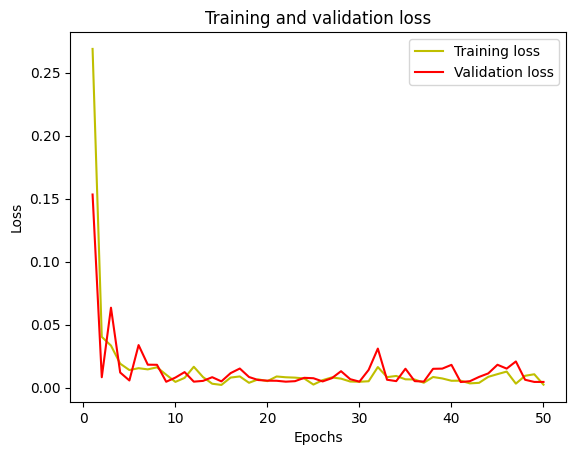

In [ ]:
print('Train...')
##########################

history = model.fit(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction on Train/Test Data

In [ ]:
#generate prediction on train and test data

trainPredict = model.predict(train_generator)
testPredict = model.predict(test_generator)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

7/7 [==============================] - 0s 4ms/step
Train Score: 787.09 RMSE
Test Score: 975.42 RMSE


**model 1**

Train Score: 787.27 RMSE

Test Score: 975.97 RMSE



In [ ]:
#plot the predictions with the actual values

#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #COnvert values to float

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset.
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict


In [ ]:
# Convert the datetime index of 'df' to a list of datetime objects
datetime_index = df.index.tolist()


In [ ]:
# Create a DataFrame with the datetime index and your numpy arrays
data = pd.DataFrame({'Datetime': datetime_index, 'Dataset': dataset.squeeze(), 'Train Predict': trainPredictPlot.squeeze(), 'Test Predict': testPredictPlot.squeeze()})

# Create a Plotly figure
fig = px.line(data, x='Datetime', y=['Dataset', 'Train Predict', 'Test Predict'], title='Your Plot Title')

# Customize the plot
fig.update_xaxes(title_text='Datetime')
fig.update_yaxes(title_text='Apparent Temperature(Celcius)')
fig.update_traces(line=dict(width=2))  # Adjust line width as needed

# Show the plot
fig.show()

## Forecast

In [ ]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 365 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    #print(current_pred)
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))




1/1 [==============================] - 0s 19ms/step


<ipython-input-25-0b8da11acfcd>:4: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-25-0b8da11acfcd>:5: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



<Axes: title={'center': 'Predictions for next 7 days'}, xlabel='time'>

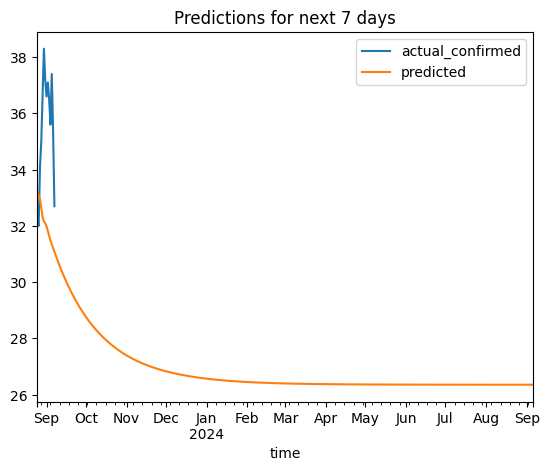

In [ ]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["apparent_temperature_mean (°C)"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")

# Saving and Loading the Model

## Saving Model

In [ ]:
# Save the trained LSTM model
model.save("drive/MyDrive/Personal/strativ/trained_lstm_model.keras")

In [ ]:


# Save the scaler variable
joblib.dump(scaler, "drive/MyDrive/Personal/strativ/temperature_scaler.pkl")

['drive/MyDrive/Personal/strativ/temperature_scaler.pkl']

## Loading Model

In [ ]:

# Load the trained LSTM model
loaded_model = keras.models.load_model("drive/MyDrive/Personal/strativ/trained_lstm_model.keras")

# Load the scaler variable
loaded_scaler = joblib.load("drive/MyDrive/Personal/strativ/temperature_scaler.pkl")

## Check the Loaded Model

In [ ]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 5 #Days
for i in range(len(test) + future):
    current_pred = loaded_model.predict(current_batch)[0]
    #print(current_pred)
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = loaded_scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

1/1 [==============================] - 0s 21ms/step


<ipython-input-36-82ea082690c2>:4: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-36-82ea082690c2>:5: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



<Axes: title={'center': 'Predictions for next 5 days'}, xlabel='time'>

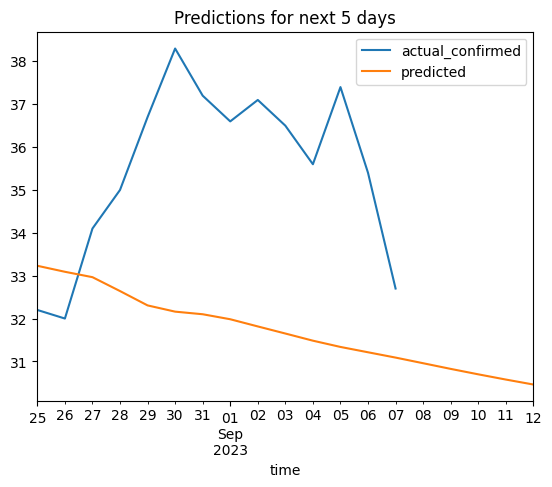

In [ ]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["apparent_temperature_mean (°C)"]

#Plot
df_forecast.plot(title="Predictions for next 5 days")

## Practise

In [ ]:
#train_scaled = scaler.transform(train)
train_scaled_2 = loaded_scaler.transform(train)

In [ ]:
train_scaled_2[:5]

array([[0.18705036],
       [0.18345324],
       [0.15467626],
       [0.16546763],
       [0.16906475]])

In [ ]:
train[:5]

,apparent_temperature_mean (°C)
time,
1940-01-02,17.1
1940-01-03,17.0
1940-01-04,16.2
1940-01-05,16.5
1940-01-06,16.6
